In [1]:
import numpy as np
import pandas as pd
from Bio import pairwise2
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics 
import ptitprince as pt
import seaborn as sns
import math
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from inspect import signature

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large' }
plt.rcParams.update(params)


In [2]:
def makeROCdata(dataframe, trueColumn, testColumn, posValue, negValue):
    trueValues = dataframe[trueColumn].tolist()
    testValues = dataframe[testColumn].tolist()
    for i in range(len(trueValues)):
        if trueValues[i] == posValue:
            trueValues[i] = 1
        if trueValues[i] == negValue:
            trueValues[i] = 0
    
    return trueValues, testValues


def longToShortVar(XXXnrYYY):
    firstAA = XXXnrYYY[:3].lower()
    number = XXXnrYYY[3:-3]
    lastAA = XXXnrYYY[-3:].lower()
    return threeToOneAA[firstAA] + number + threeToOneAA[lastAA]


def heatmapData(seq,aaList,dataList):
    i = 0
    aaArray = []
    [aaArray.append([]) for aa in aaList]
    for j in range(len(seq)):
        for k in range(len(aaList)):
            aaArray[k].append(dataList[i])
            i += 1
    return aaArray

def posToCertain(x):
    if x == 'possibly_wt-like':
        return 'wt-like'
    elif x == 'possibly_low':
        return 'low'
    elif x == 'dominant_negative':
        return 'low'
    else:
        return x
    
def getThreshold(ROCdata):
    pointDists = []
    threshold = 0
    for point in range(len(ROCdata[0])):
        x = ROCdata[0][point]
        y = ROCdata[1][point]
        dist = math.sqrt(x**2  + (1-y)**2)
        pointDists.append(dist)

    for j in range(len(pointDists)):
        if pointDists[j] == min(pointDists):
            threshold += ROCdata[2][j]
    return threshold



In [3]:
threeToOneAA = {'ala':'A','arg':'R','asn':'N','asp':'D','cys':'C','glu':'E','gln':'Q','gly':'G','his':'H',\
                'ile':'I','leu':'L','lys':'K','met':'M','phe':'F','pro':'P','ser':'S','thr':'T','trp':'W',\
                'tyr':'Y','val':'V'}
oneToThreeAA = {v: k for k, v in threeToOneAA.items()}

#Sequence taken from https://www.uniprot.org/uniprot/P60484#sequences
PTENgenSeq = 'MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSK\
HKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVA\
AIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSY\
LLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMY\
FEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEI\
DSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEAS\
SSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV'

#Sequence taken from PDB: 1D5R
PTENpdbSeq = 'MIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVA\
QYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGV\
TIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQP\
LPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEEVDNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTK\
TVEE'


'''
Global alignment is used with very high rewards is given for a match.
A very high penalty is given for a mismatch.
A very high penalty is given for a gap opening.
A very low penalty is given for a gap extension.
'''
alignments = pairwise2.align.globalms(PTENgenSeq,PTENpdbSeq,30,-30,-20,-1)
alignments

[('MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV',
  'M------IVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEE----V-------------------DNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEE--------------------------------------------------',
  9565.0,
  0,
  403)]

In [4]:
PTENgenSeqAligned = alignments[0][0]
PTENpdbSeqAligned = alignments[0][1]

aaList = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']

genSeqList = []
genNrList = []
pdbSeqList = []
allVariants = []

for nr in range(len(PTENgenSeqAligned)):
    for aa in aaList:
        allVariants.append(PTENgenSeqAligned[nr]+str(nr+1)+aa)
        genSeqList.append(PTENgenSeqAligned[nr])
        genNrList.append(str(nr+1))
        if PTENpdbSeqAligned[nr] != '-':
            pdbSeqList.append(True)
        else:
            pdbSeqList.append(False)
        


In [5]:
'''
Import the VAMP-seq data
'''

ptenVAMPseq = pd.read_csv('data/PTEN.csv')
ptenVAMPseq = ptenVAMPseq.set_index('variant')
ptenVAMPseq = ptenVAMPseq[ptenVAMPseq['class'] == 'missense']
ptenVAMPseq = ptenVAMPseq.dropna(subset=['abundance_class'])
ptenVAMPseq.rename(columns={'score':'abundance_score'},inplace=True)
VAMPseqAbundance = ptenVAMPseq[['abundance_class','abundance_score']] #+ ptenVAMPseq['abundance_score']

/home/michael/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (33,88,89,90,120,121,122,123,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
'''
Create the variants dataframe
'''
data = {'Seq':genSeqList,'Seq_number':genNrList,'in_PDB':pdbSeqList}
variantsDataframe = pd.DataFrame.from_dict(data)
variantsDataframe.index = allVariants
variantsDataframe.index.name='Variant'
variantsDataframe = pd.concat([variantsDataframe,VAMPseqAbundance],axis=1,sort=False)

In [7]:
'''
Import the Rosetta ddG values
'''

with open('data/rosetta_ddg.txt') as rosetta_ddg:
    rosetta = rosetta_ddg.readlines()
    

rosettaValues = []    
for line in rosetta:
    stripline = line.strip().split()
    #ddg = float(stripline[5])
    #stripline = stripline[:3]
    #stripline.append(ddg)
    rosettaValues.append(stripline)



rosettaIndex = []
rosettaDDG = []
for line in rosettaValues:
    rosettaIndex.append(line[1]+line[0]+line[2])
    rosettaDDG.append(line[3])
    
rosettaDataFrame = pd.DataFrame.from_dict({'Rosetta_ddg':rosettaDDG})
rosettaDataFrame.index = rosettaIndex
rosettaDataFrame.Rosetta_ddg = rosettaDataFrame.Rosetta_ddg.astype(float)

variantsDataframe = pd.concat([variantsDataframe,rosettaDataFrame],axis=1,sort=False)


In [8]:
'''
Import the functional DMS data 
'''


xlsFuncDMS = pd.ExcelFile('data/mmc2.xlsx')
funcDMSDF = pd.read_excel(xlsFuncDMS,'Table S2')
funcDMSDF.columns = funcDMSDF.loc[0]
funcDMSDF = funcDMSDF.drop(0)
funcDMSDF = funcDMSDF.rename(columns={'Variant (one letter)':'variant'})
funcDMSDF.set_index('variant', inplace=True)
funcDMSDF = funcDMSDF[(funcDMSDF['High_conf'] == True)]
funcDMSDF['Cum_score'] = funcDMSDF['Cum_score'].astype(float)
funcDMSDF = funcDMSDF[funcDMSDF['Type'] == 'missense']
funcDMSscores = funcDMSDF['Cum_score']

variantsDataframe = pd.concat([variantsDataframe,funcDMSscores.rename("functional_score")],axis=1,sort=False)

In [9]:
"""
Import Gremlin
"""

#PTENgenSeq
gremlinData = pd.read_csv('data/covar_2D.dat',sep = "\t", header = None)
gremlinData = gremlinData.transpose()
gremlinData.columns = gremlinData.iloc[0]
gremlinData = gremlinData.drop(0)
gremlinData.AA = gremlinData["AA"].astype(int)
gremlinData = gremlinData.set_index("AA")
gremlinDic = {} 
for nr in range(len(PTENgenSeq)):
        for aa in aaList:
            gremlinDic[PTENgenSeq[nr]+str(nr+1)+aa] =\
            gremlinData.loc[nr+1,aa]
gremlinDF = pd.DataFrame.from_dict(gremlinDic,orient = "index",columns=["gremlin"])

variantsDataframe = pd.concat([variantsDataframe,gremlinDF], axis = 1, sort = False)

In [10]:
'''
Import ClinVar data
'''

clinvarDataframe = pd.read_csv('data/clinvar_missense_high_quality.csv')
clinvarDataframe['variant']=clinvarDataframe.apply(lambda x:x['AA.wt'] + str(x['pos']) + x['AA.mut'],axis=1)
clinvarDataframe = clinvarDataframe.set_index('variant')
clinvarDataframe = clinvarDataframe.rename(columns = {'simplified.significance':'significance'})

In [11]:
'''
Import gnomAD 
'''
gnomADDataFrame = pd.read_csv('data/gnomAD_v2.1.1_ENSG00000171862_2019_03_14_09_09_24.csv')
#gnomADDataFrame.drop(gnomADDataFrame.columns[-30:],axis=1)
gnomADDataFrame = gnomADDataFrame[['Protein Consequence','Allele Count']]
gnomADDataFrame['Protein Consequence'] = gnomADDataFrame.apply(lambda x: longToShortVar(x['Protein Consequence'][2:]),axis=1)
gnomADDataFrame['significance'] = 'gnomAD'
gnomADDataFrame = gnomADDataFrame.rename(columns={'Protein Consequence':'variant'})
gnomADDataFrame = gnomADDataFrame.set_index('variant')
clinicalDF = pd.concat([gnomADDataFrame,clinvarDataframe], sort = False)
clinicalDF = clinicalDF[['significance','Allele Count']]
#Check for duplicates between ClinVar and gnomAD
clinicalDF[clinicalDF.index.duplicated() == True]

,significance,Allele Count
variant,,
K289E,(likely) pathogenic,NaN
R173H,(likely) pathogenic,NaN
R15S,(likely) pathogenic,NaN


In [12]:
#The duplicates
clinicalDF.loc[['K289E','R173H','R15S']]

,significance,Allele Count
variant,,
K289E,gnomAD,3.0
K289E,(likely) pathogenic,NaN
R173H,gnomAD,2.0
R173H,(likely) pathogenic,NaN
R15S,(likely) pathogenic,NaN
R15S,(likely) pathogenic,NaN


In [13]:
#Drop the benign duplicates
clinicalDF = clinicalDF.reset_index().drop_duplicates(subset='variant',keep='last')
clinicalDF = clinicalDF.set_index('variant')
variantsDataframe.index = variantsDataframe.index.rename('variant')
variantsDataframe = pd.concat([variantsDataframe,clinicalDF],axis=1, sort=False)
#Add known benign variants
certainList = ['D268E','A79T','P354Q','S294R','Y377F','M205V','Q298E'] 
benignDF = variantsDataframe.loc[certainList]
benignDF['significance'] = 'benign'
benignIndex = [x+'benign' for x in certainList]
benignDF['benignIndex'] = benignIndex
benignDF = benignDF.set_index('benignIndex')
benignDF.index.name = ''
benignAddedDF = variantsDataframe
#benignAddedDF.loc[certainList,'significance'] = "benign"
benignAddedDF = pd.concat([variantsDataframe,benignDF], axis = 0, sort = False)
clinicalDF = benignAddedDF[~benignAddedDF['significance'].isnull()]
benignPrunedDF = benignAddedDF.dropna(subset= ['abundance_class','Rosetta_ddg','functional_score','gremlin'])
#Make all predictors have the same variants 
variantsPrunedDF = variantsDataframe.dropna(subset= ['abundance_class','Rosetta_ddg','functional_score'])

#Final DF with 71 variants that have data from all experiments and have clinical data
variantsSeqDF = variantsPrunedDF[~variantsPrunedDF['significance'].isnull()]


In [14]:
#gnomAD variants missing in the different experiments
gnomADDF = clinicalDF[clinicalDF.significance == 'gnomAD']
print("VAMP-seq:",gnomADDF[gnomADDF.abundance_score.isnull()].shape[0])
print("Rosetta:",gnomADDF[gnomADDF.Rosetta_ddg.isnull()].shape[0])
print("Phosphatase-MAVE:",gnomADDF[gnomADDF.functional_score.isnull()].shape[0])
print("Benign variants with total overlap:",gnomADDF.dropna().shape[0])

VAMP-seq: 32
Rosetta: 28
Phosphatase-MAVE: 3
Benign variants with total overlap: 29


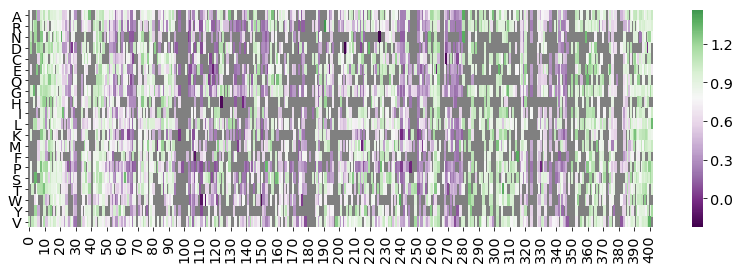

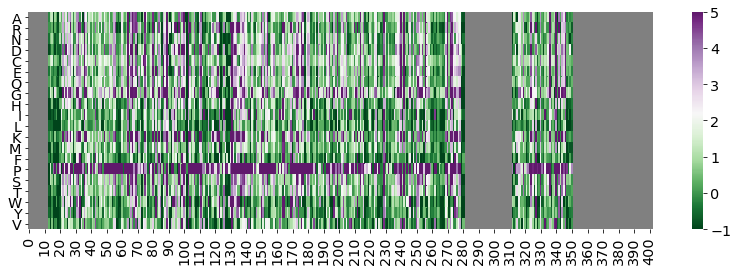

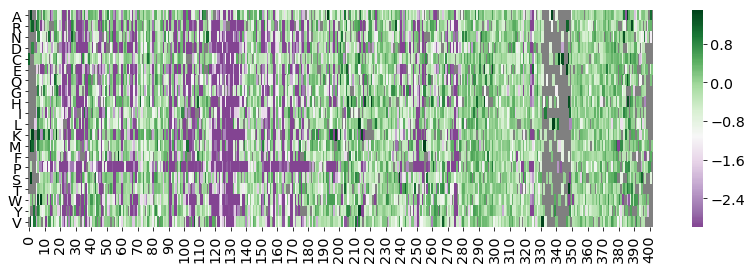

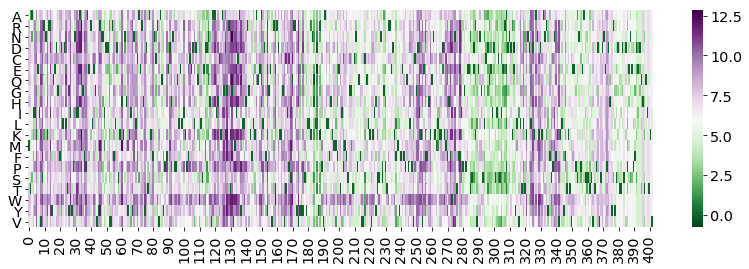

In [15]:
#Figure 1: Heatmaps
#colors = sns.diverging_palette(10,240,s=99,as_cmap = True)
colors = "PRGn"
colors_r = "PRGn_r"
vampHeatmapData = np.array(heatmapData(PTENgenSeq, aaList, list(variantsDataframe['abundance_score'])))
rosettaddgHeatmapData = heatmapData(PTENgenSeq, aaList, list(variantsDataframe['Rosetta_ddg']))
funcHeatmapData = heatmapData(PTENgenSeq,aaList, list(variantsDataframe['functional_score']))
gremlinHeatmapData = heatmapData(PTENgenSeq,aaList, list(variantsDataframe['gremlin']))

#colors = ["#af8dc3","#7fbf7b"]
#colors_r = ["#7fbf7b","#af8dc3"]
a4_dims = (14, 4)
fig, ax = plt.subplots(figsize=a4_dims)

sns_figure = sns.heatmap(vampHeatmapData,
                         #linewidths=0.01, 
                         cmap=colors,center=0.78,
                         yticklabels=aaList)
ax.patch.set(hatch='xxxxxxxxxxxxxxxxxxx', edgecolor='grey')
fig = sns_figure.get_figure()
fig.savefig("plots/heatmap/heatmap_VAMP-seq.pdf")


a4_dims = (14, 4)
fig, ax = plt.subplots(figsize=a4_dims)

sns_figure = sns.heatmap(rosettaddgHeatmapData,
                         vmin = -1,
                         vmax = 5,
                         cmap=colors_r,
                         center=2.2,
                         yticklabels=aaList)
ax.patch.set(hatch='xxxxxxxxxxxxxxxxxxx', edgecolor='grey')
fig = sns_figure.get_figure()
fig.savefig("plots/heatmap/heatmap_Rosetta-ddg.pdf")

a4_dims = (14, 4)
fig, ax = plt.subplots(figsize=a4_dims)

sns_figure = sns.heatmap(funcHeatmapData,
                         vmin = -3,
                         vmax = 1.5,
                         cmap=colors,
                         center=-1.11,
                         yticklabels=aaList)
ax.patch.set(hatch='xxxxxxxxxxxxxx', edgecolor='grey')
fig = sns_figure.get_figure()
fig.savefig("plots/heatmap/heatmap_functional-DMS.pdf")

a4_dims = (14, 4)
fig, ax = plt.subplots(figsize=a4_dims)

sns_figure = sns.heatmap(gremlinHeatmapData,
                         cmap=colors_r,center=6,
                         yticklabels=aaList,
                        )

ax.patch.set(hatch='xxxxxxxxxxxxxx', edgecolor='grey')
fig = sns_figure.get_figure()
fig.savefig("plots/heatmap/heatmap_gremlin.pdf")




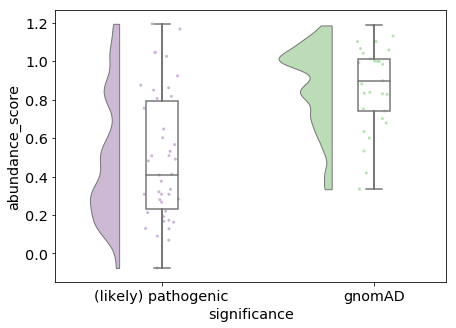

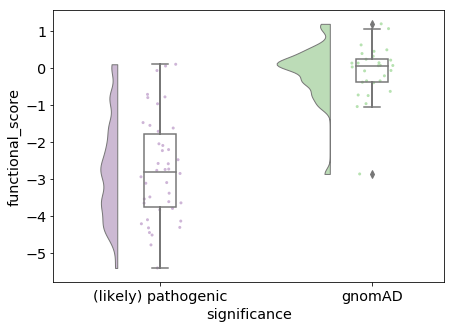

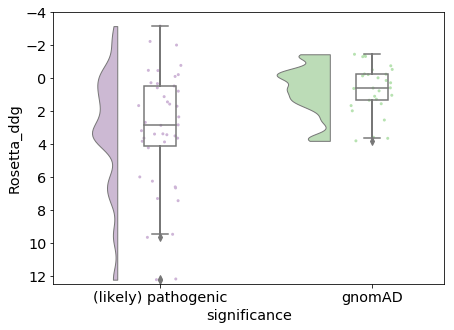

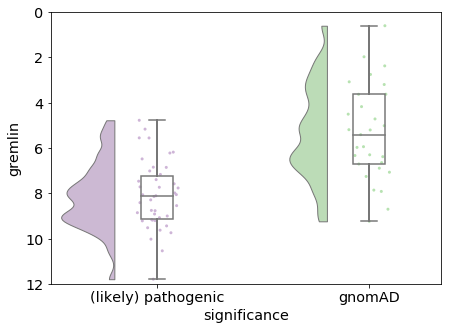

In [16]:
#Figure 3: Raincloud plots
#Groups1: pathogenic, gnomAD, benign
#variantsPrunedDF = variantsDataframe.drop(['A79T','M205V'])
colour = 'PRGn'
dx = "significance";  ort = "v"; pal = colour; sigma = .2
dy = "abundance_score"
ax=pt.RainCloud(x = dx, y = dy, data = variantsPrunedDF, palette = pal, bw = sigma, alpha = 1,
                 width_viol = .5, figsize = (7,5), orient = ort)

#plt.ylim(1.5,-0.1)

plt.savefig('plots/raincloud/raincloud_VAMP-seq.pdf')

dy = "functional_score"
ax=pt.RainCloud(x = dx, y = dy, data = variantsPrunedDF, palette = pal, bw = sigma, alpha = 1,
                 width_viol = .5, figsize = (7,5), orient = ort)

#plt.ylim(1.4,-6)

plt.savefig('plots/raincloud/raincloud_phosphatase-mave.pdf')

dy = "Rosetta_ddg"
ax=pt.RainCloud(x = dx, y = dy, data = variantsPrunedDF, palette = pal, bw = sigma, alpha = 1,
                 width_viol = .5, figsize = (7,5), orient = ort)
plt.ylim(12.5,-4)

plt.savefig('plots/raincloud/raincloud_rosetta-ddg.pdf')

dy = "gremlin"
ax=pt.RainCloud(x = dx, y = dy, data = variantsPrunedDF, palette = pal, bw = sigma, alpha = 1,
                 width_viol = .5, figsize = (7,5), orient = ort)
plt.ylim(12,0)

plt.savefig('plots/raincloud/raincloud_gremlin.pdf')


#The code for plotting rainclouds has been taken directly from: 
#https://github.com/RainCloudPlots/RainCloudPlots/blob/master/tutorial_python/raincloud_tutorial_python.ipynb



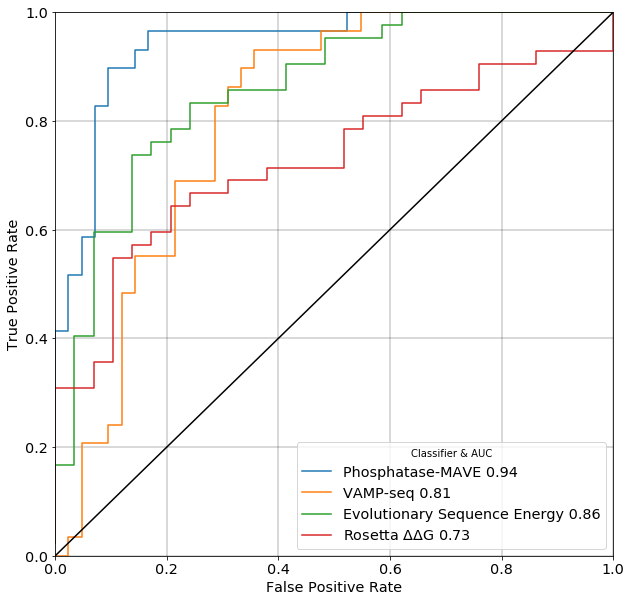

In [17]:
#Figure 4: ROC for pathogenicity
#Fn, VAMP and functional as classifiers

#Rosetta
RosPredict = list(makeROCdata(variantsSeqDF,'significance','Rosetta_ddg','gnomAD','(likely) pathogenic'))
RosPredictROC = metrics.roc_curve(RosPredict[0],RosPredict[1], pos_label= 0)
RosAUC = round(metrics.roc_auc_score(RosPredict[0],RosPredict[1]),2)

#VAMP-seq
vampPredict = list(makeROCdata(variantsSeqDF,'significance','abundance_score','gnomAD','(likely) pathogenic'))
VampPredictROC = metrics.roc_curve(vampPredict[0],vampPredict[1])
VampAUC = round(metrics.roc_auc_score(vampPredict[0],vampPredict[1]),2)

#Functional DMS
funcPreClin = list(makeROCdata(variantsSeqDF,'significance','functional_score','gnomAD','(likely) pathogenic'))
funcPreClinROC = metrics.roc_curve(funcPreClin[0],funcPreClin[1])
funcPreClinAUC = round(metrics.roc_auc_score(funcPreClin[0],funcPreClin[1]),2)

#Functional DMS
gremPreClin = list(makeROCdata(variantsSeqDF,'significance','gremlin','gnomAD','(likely) pathogenic'))
gremPreClinROC = metrics.roc_curve(gremPreClin[0],gremPreClin[1],pos_label=0)
gremPreClinAUC = round(metrics.roc_auc_score(gremPreClin[0],gremPreClin[1]),2)

rosThres = getThreshold(RosPredictROC)
gremThres = getThreshold(gremPreClinROC)
funcThres = getThreshold(funcPreClinROC)
vampThres = getThreshold(VampPredictROC)

#Plot
a4_dims = (10,10)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xlim([0,1])
plt.ylim([0,1])

plt.plot(funcPreClinROC[0],funcPreClinROC[1], label = 'Phosphatase-MAVE ' + str(funcPreClinAUC))
plt.plot(VampPredictROC[0],VampPredictROC[1], label = 'VAMP-seq ' + str(VampAUC))
plt.plot(gremPreClinROC[0],gremPreClinROC[1], label = 'Evolutionary Sequence Energy ' + str(1 - gremPreClinAUC))
plt.plot(RosPredictROC[0],RosPredictROC[1], label = 'Rosetta $\Delta\Delta$G ' + str(1 - RosAUC))

#plt.plot(gremPreClinROC[0],gremPreClinROC[1], label = 'Gremlin ' + str(1 - gremPreClinAUC))

plt.plot(np.arange(-0.1,1.1,0.1),np.arange(-0.1,1.1,0.1), color = 'BLACK')
ax.grid(color='black', linestyle='-', linewidth=0.3)
ax.set_facecolor('white')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(title ='Classifier & AUC')
plt.savefig('plots/ROC/ROC-curve.pdf')



In [18]:
#F1 values at optimal threshold from the ROC curve analysis

[RosPredict,0,'rosetta_ddg'],
[gremPreClin,0,'gremlin'],
[vampPredict,1,'vamp-seq'],
[funcPreClin,1,'phosphatase-MAVE']
predictors = [
[RosPredict,rosThres,True,"rosetta_ddg"],
[gremPreClin,gremThres,True,"gremlin"],
[vampPredict,vampThres,False,"vamp-seq"],
[funcPreClin,funcThres,False,"phosphatase-MAVE"]
]
for predictor in predictors:
    
    method = predictor[0]
    threshold = predictor[1]
    reverse = predictor[2]
    predictDict = {'classification': method[0], 'values': method[1]}
    predictDF = pd.DataFrame.from_dict(predictDict)

    pathoLength = predictDF[predictDF.classification == 0].shape[0]
    #cutOffs
    cutOffs = list(predictDF['values'])
    cutOffs.sort()
    cutOffs.reverse()
    cutOffs
    for value in [threshold]:
        predictions = []
        if reverse == True:
            for j in method[1]:
                if j < value:
                    predictions.append(1)
                else:
                    predictions.append(0)    
        else:
            for j in method[1]:
                if j > value:
                    predictions.append(1)
                else:
                    predictions.append(0)
        print(predictor[3],value, metrics.f1_score(method[0],predictions))

rosetta_ddg 1.457 0.676923076923077
gremlin 6.85125 0.7586206896551724
vamp-seq 0.6791217189259251 0.71875
phosphatase-MAVE -0.742967177 0.8620689655172413


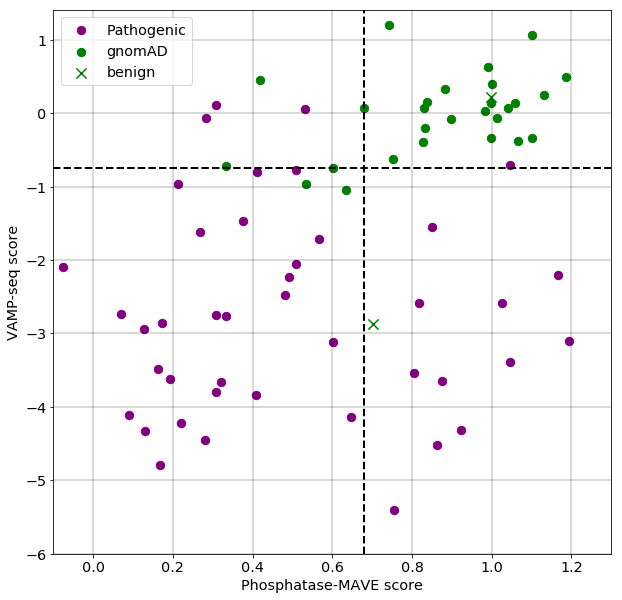

In [19]:
#Color VAMP-func scatter plot according to pathogenic and benign 

variantsSeqDF
pathoDF = variantsSeqDF[variantsSeqDF.significance == '(likely) pathogenic']
gnomDF = variantsSeqDF[variantsSeqDF.significance == 'gnomAD']
benignDF = gnomDF.loc[['A79T','M205V']]
gnomDF = gnomDF.drop(['A79T','M205V']) #remove known benign


patho_func = pathoDF.functional_score
patho_vamp = pathoDF.abundance_score
patho_grem = pathoDF.gremlin
patho_ros = pathoDF.Rosetta_ddg
gnom_func = gnomDF.functional_score
gnom_vamp = gnomDF.abundance_score
gnom_grem = gnomDF.gremlin
gnom_ros = gnomDF.Rosetta_ddg
benign_func = benignDF.functional_score
benign_vamp = benignDF.abundance_score
benign_grem = benignDF.gremlin
benign_ros = benignDF.Rosetta_ddg

size = 70
fig, ax = plt.subplots(figsize = [10,10])
#colors = ['green','red']
#ax.scatter(func_score,ab_score, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(patho_vamp,patho_func, color = 'purple', s = size, label = 'Pathogenic')
plt.scatter(gnom_vamp,gnom_func, color = 'green', s = size, label = 'gnomAD')
plt.scatter(benign_vamp,benign_func, color = 'green', s = 1.5*size, label = 'benign',marker = "x")
ax.grid(color='black', linestyle='-', linewidth=0.3)
#plt.axvline(x = 0.71, linewidth = 2, color = 'black', linestyle = '--')
plt.axvline(x = vampThres, linewidth = 2, color = 'black', linestyle = '--')
#plt.axhline(y = -1.11, linewidth = 2, color = 'black', linestyle = '--')
plt.axhline(y = funcThres, linewidth = 2, color = 'black', linestyle = '--')
plt.ylim(-6,1.4)
plt.xlim(-0.1,1.3)
plt.legend(markerscale = 1)
ax.set_ylabel('VAMP-seq score')
ax.set_xlabel('Phosphatase-MAVE score')
plt.savefig('plots/scatter/scatterplot_VAMPseq-functional.pdf')

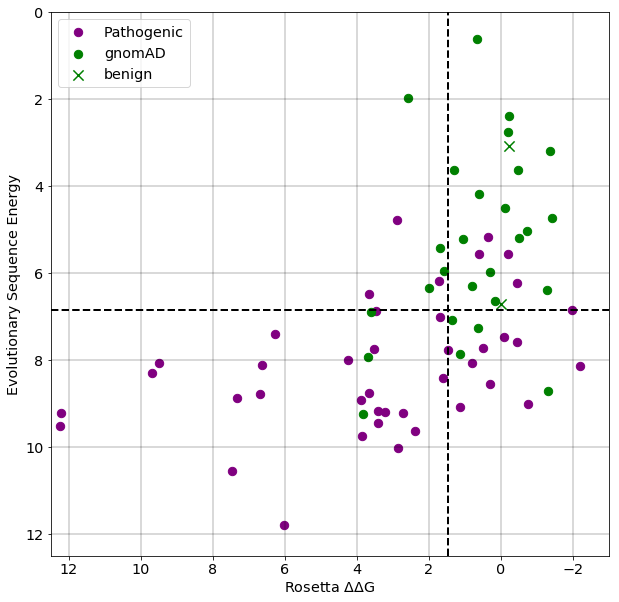

In [20]:

fig, ax = plt.subplots(figsize = [10,10])
#colors = ['green','red']
#ax.scatter(func_score,ab_score, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(patho_ros,patho_grem, color = 'purple', s = size, label = 'Pathogenic')
plt.scatter(gnom_ros,gnom_grem, color = 'green', s = size, label = 'gnomAD')
plt.scatter(benign_ros,benign_grem, color = 'green', s = 1.5*size, label = 'benign', marker = 'x')

ax.grid(color='black', linestyle='-', linewidth=0.3)
plt.axhline(y = gremThres, linewidth = 2, color = 'black', linestyle = '--')
plt.axvline(x = rosThres, linewidth = 2, color = 'black', linestyle = '--')
plt.legend(markerscale = 1)
plt.xlim(12.5,-3)
plt.ylim(12.5,0)
ax.set_xlabel('Rosetta $\Delta\Delta$G')
ax.set_ylabel('Evolutionary Sequence Energy')
plt.savefig('plots/scatter/scatterplot_Rosetta-gremlin.pdf')

In [21]:
#Figure 4 values
print("Pathogenic variants:",pathoDF.shape[0])
print("Lower left corner, experimental:",pathoDF[(pathoDF.abundance_score < vampThres) & 
             (pathoDF.functional_score < funcThres)].shape[0])
print("Lower left corner, computantional",pathoDF[(pathoDF.Rosetta_ddg > rosThres) &
                (pathoDF.gremlin > gremThres)].shape[0])

Pathogenic variants: 42
Lower left corner, experimental: 27
Lower left corner, computantional 24


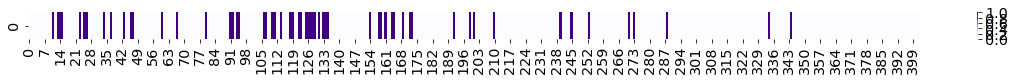

In [22]:
pathoSequence = variantsDataframe[variantsDataframe.significance =="(likely) pathogenic"
                                 ].Seq_number.astype("float").unique()

seqNumber = []
pathoNumber = []
certainSeq = [79,268,354,294,377,205,298]
certainNumber = []
for aa in range(1,len(PTENgenSeq)+1):
    if float(aa) in pathoSequence:
        pathoNumber.append(1)
    else:
        pathoNumber.append(0)
    seqNumber.append(aa)
    if aa in certainSeq:
        certainNumber.append(1)
    else:
        certainNumber.append(0)
fig, ax = plt.subplots(figsize = [20,0.5])
sns.heatmap([pathoNumber], cmap = 'Purples')
plt.savefig('plots/pathogenic_variants.pdf')